In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import torch

import sys
sys.path.append("/home/zihend1/Diffusion/DISCO/DISCO")

from baseline import RandomRegion, TissueSpecificRandomRegion, KNNClustering, VAE, GANBaseline, LatentSpaceGAN
from data import load_test_data
from evaluate import Evaluator
from utils import *
from script_train_vae import load_vae_model
from script_train_gan import load_gan_model
from script_train_lgan import load_lgan_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Seeding all randomness with seed=2024


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
all_test_items = load_test_data(num_holes=1)

Seeding all randomness with seed=2024
Donor_id: MsBrainAgingSpatialDonor_1
Slice_id: 0
Donor_id: MsBrainAgingSpatialDonor_2
Slice_id: 0
Slice_id: 1
Donor_id: MsBrainAgingSpatialDonor_3
Slice_id: 0
Slice_id: 1
Donor_id: MsBrainAgingSpatialDonor_4
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_5
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_6
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_7
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_8
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_9
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_10
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_11
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_12
Slice_id: 0
Slice_id: 1


In [ ]:
# Initialize a nested dictionary to store metrics for each tissue
# tissues = ['striatum', 'cortical layer VI', 'cortical layer V', 'corpus callosum',
#            'cortical layer II/III', 'olfactory region', 'pia mater', 'brain ventricle']

tissues = ['striatum', 'cortical layer VI', 'cortical layer V', 'corpus callosum',
           'cortical layer II/III']

metrics = {
    tissue: {
        'RandomRegion': {
            'mse': [],
            'l1': [],
            'cosine_sim': [],
            'chamfer_dist': [],
            'emd': []
        },
        'TissueSpecificRandomRegion': {
            'mse': [],
            'l1': [],
            'cosine_sim': [],
            'chamfer_dist': [],
            'emd': []
        },
        'KNN': {
            'mse': [],
            'l1': [],
            'cosine_sim': [],
            'chamfer_dist': [],
            'emd': []
        },
        'GeneralVAE': {
            'mse': [],
            'l1': [],
            'cosine_sim': [],
            'chamfer_dist': [],
            'emd': []
        },
        'TissueVAE': {
            'mse': [],
            'l1': [],
            'cosine_sim': [],
            'chamfer_dist': [],
            'emd': []
        },
        'GeneralGAN': {
            'mse': [],
            'l1': [],
            'cosine_sim': [],
            'chamfer_dist': [],
            'emd': []
        },
        'TissueGAN': {
            'mse': [],
            'l1': [],
            'cosine_sim': [],
            'chamfer_dist': [],
            'emd': []
        },
        'GeneralLGAN': {
            'mse': [],
            'l1': [],
            'cosine_sim': [],
            'chamfer_dist': [],
            'emd': []
        },
        'TissueLGAN': {
            'mse': [],
            'l1': [],
            'cosine_sim': [],
            'chamfer_dist': [],
            'emd': []
        }
    } for tissue in tissues
}

In [6]:
random_baseline = RandomRegion()
tissue_random_baseline = TissueSpecificRandomRegion()
KNN_baseline = KNNClustering()

base_save_path = "/home/zihend1/Diffusion/DISCO/DISCO/saved_models/"

In [ ]:
# Evaluation loop
for i, test_item in enumerate(all_test_items):
    dominant_tissue = test_item.test_area.dominant_tissue
    leave_out_donor = test_item.meta_data['donor_id']
    print(f"Test Area {i+1}:")
    print(f"  Dominant Tissue: {test_item.test_area.dominant_tissue}")
    print(f"  Number of cells in ground truth: {len(test_item.ground_truth.hole_cells)}")
    true_coords = test_item.ground_truth.hole_cells[['center_x', 'center_y']].values
    true_gene_expressions = test_item.ground_truth.gene_expression

    # Define paths for general and tissue-specific VAE models
    general_vae_path = Path(base_save_path) / f"leave_out_donor_{sanitize_name(leave_out_donor)}" / "general" / f"vae_general.pth"
    tissue_vae_path = Path(base_save_path) / f"leave_out_donor_{sanitize_name(leave_out_donor)}" / f"tissue_{sanitize_name(dominant_tissue)}" / f"vae_tissue_{sanitize_name(dominant_tissue)}.pth"

    # Define paths for general and tissue-specific GAN models
    general_gan_path = Path(base_save_path) / f"leave_out_donor_{sanitize_name(leave_out_donor)}" / "general"
    tissue_gan_path = Path(base_save_path) / f"leave_out_donor_{sanitize_name(leave_out_donor)}" / f"tissue_{sanitize_name(dominant_tissue)}"

    general_lgan_path = general_gan_path
    tissue_lgan_path = tissue_gan_path
    
    # Apply RandomRegion
    random_coords, random_gene_expressions = random_baseline.fill_region(test_item.adata, test_item.test_area)
    mse_r, l1_r, cosine_sim_r = Evaluator.evaluate_expression(true_coords, true_gene_expressions, random_coords, random_gene_expressions)
    chamfer_dist_r = Evaluator.chamfer_distance(true_coords, random_coords)
    emd_r = Evaluator.calculate_emd(true_coords, random_coords)
    # visualize_coords(true_coords, random_coords, "random")

    # Apply TissueSpecificRandomRegion
    tissue_coords, tissue_gene_expressions = tissue_random_baseline.fill_region(test_item.adata, test_item.test_area)
    mse_tr, l1_tr, cosine_sim_tr = Evaluator.evaluate_expression(true_coords, true_gene_expressions, tissue_coords, tissue_gene_expressions)
    chamfer_dist_tr = Evaluator.chamfer_distance(true_coords, tissue_coords)
    emd_tr = Evaluator.calculate_emd(true_coords, tissue_coords)
    # visualize_coords(true_coords, tissue_coords, "tissue random")

    # Apply KNN
    KNN_coords, KNN_gene_expressions = KNN_baseline.fill_region(test_item.adata, test_item.test_area)
    mse_knn, l1_knn, cosine_sim_knn = Evaluator.evaluate_expression(true_coords, true_gene_expressions, KNN_coords, KNN_gene_expressions)
    chamfer_dist_knn = Evaluator.chamfer_distance(true_coords, KNN_coords)
    emd_knn = Evaluator.calculate_emd(true_coords, KNN_coords)
    # visualize_coords(true_coords, KNN_coords, "knn")

    # Apply General VAE
    vae_general = load_vae_model(general_vae_path, device)
    vae_coords_general, vae_gene_expressions_general = vae_general.fill_region(test_item.adata, test_item.test_area)
    mse_vae_g, l1_vae_g, cosine_sim_vae_g = Evaluator.evaluate_expression(true_coords, true_gene_expressions, vae_coords_general, vae_gene_expressions_general)
    chamfer_dist_vae_g = Evaluator.chamfer_distance(true_coords, vae_coords_general)
    emd_vae_g = Evaluator.calculate_emd(true_coords, vae_coords_general)
    # visualize_coords(true_coords, vae_coords_general, "general vae")

    # Apply Tissue-Specific VAE
    vae_tissue = load_vae_model(tissue_vae_path, device)
    vae_coords_tissue, vae_gene_expressions_tissue = vae_tissue.fill_region(test_item.adata, test_item.test_area)
    mse_vae_t, l1_vae_t, cosine_sim_vae_t = Evaluator.evaluate_expression(true_coords, true_gene_expressions, vae_coords_tissue, vae_gene_expressions_tissue)
    chamfer_dist_vae_t = Evaluator.chamfer_distance(true_coords, vae_coords_tissue)
    emd_vae_t = Evaluator.calculate_emd(true_coords, vae_coords_tissue)
    # visualize_coords(true_coords, vae_coords_tissue, "tissue vae")
    
    # Apply General GAN
    gan_general = load_gan_model(general_gan_path, device)
    gan_coords_general, gan_gene_expressions_general = gan_general.fill_region(test_item.adata, test_item.test_area)
    mse_gan_g, l1_gan_g, cosine_sim_gan_g = Evaluator.evaluate_expression(true_coords, true_gene_expressions, gan_coords_general, gan_gene_expressions_general)
    chamfer_dist_gan_g = Evaluator.chamfer_distance(true_coords, gan_coords_general)
    emd_gan_g = Evaluator.calculate_emd(true_coords, gan_coords_general)
    # visualize_coords(true_coords, gan_coords_general, "general gan")

    # Apply Tissue-Specific GAN
    gan_tissue = load_gan_model(tissue_gan_path, device)
    gan_coords_tissue, gan_gene_expressions_tissue = gan_tissue.fill_region(test_item.adata, test_item.test_area)
    mse_gan_t, l1_gan_t, cosine_sim_gan_t = Evaluator.evaluate_expression(true_coords, true_gene_expressions, gan_coords_tissue, gan_gene_expressions_tissue)
    chamfer_dist_gan_t = Evaluator.chamfer_distance(true_coords, gan_coords_tissue)
    emd_gan_t = Evaluator.calculate_emd(true_coords, gan_coords_tissue)
    # visualize_coords(true_coords, gan_coords_tissue, "tissue gan")
    
    # Apply General LGAN
    lgan_general = load_lgan_model(general_lgan_path, device)
    lgan_coords_general, lgan_gene_expressions_general = lgan_general.fill_region(test_item.adata, test_item.test_area)
    mse_lgan_g, l1_lgan_g, cosine_sim_lgan_g = Evaluator.evaluate_expression(true_coords, true_gene_expressions, lgan_coords_general, lgan_gene_expressions_general)
    chamfer_dist_lgan_g = Evaluator.chamfer_distance(true_coords, lgan_coords_general)
    emd_lgan_g = Evaluator.calculate_emd(true_coords, lgan_coords_general)
    # visualize_coords(true_coords, lgan_coords_general, "general lgan")

    # Apply Tissue-Specific LGAN
    lgan_tissue = load_lgan_model(tissue_lgan_path, device)
    lgan_coords_tissue, lgan_gene_expressions_tissue = lgan_tissue.fill_region(test_item.adata, test_item.test_area)
    mse_lgan_t, l1_lgan_t, cosine_sim_lgan_t = Evaluator.evaluate_expression(true_coords, true_gene_expressions, lgan_coords_tissue, lgan_gene_expressions_tissue)
    chamfer_dist_lgan_t = Evaluator.chamfer_distance(true_coords, lgan_coords_tissue)
    emd_lgan_t = Evaluator.calculate_emd(true_coords, lgan_coords_tissue)
    # visualize_coords(true_coords, lgan_coords_tissue, "tissue lgan")

    # Collect results for RandomRegion
    metrics[dominant_tissue]['RandomRegion']['mse'].append(mse_r)
    metrics[dominant_tissue]['RandomRegion']['l1'].append(l1_r)
    metrics[dominant_tissue]['RandomRegion']['cosine_sim'].append(cosine_sim_r)
    metrics[dominant_tissue]['RandomRegion']['chamfer_dist'].append(chamfer_dist_r)
    metrics[dominant_tissue]['RandomRegion']['emd'].append(emd_r)

    # Collect results for TissueSpecificRandomRegion
    metrics[dominant_tissue]['TissueSpecificRandomRegion']['mse'].append(mse_tr)
    metrics[dominant_tissue]['TissueSpecificRandomRegion']['l1'].append(l1_tr)
    metrics[dominant_tissue]['TissueSpecificRandomRegion']['cosine_sim'].append(cosine_sim_tr)
    metrics[dominant_tissue]['TissueSpecificRandomRegion']['chamfer_dist'].append(chamfer_dist_tr)
    metrics[dominant_tissue]['TissueSpecificRandomRegion']['emd'].append(emd_tr)

    # Collect results for KNN
    metrics[dominant_tissue]['KNN']['mse'].append(mse_knn)
    metrics[dominant_tissue]['KNN']['l1'].append(l1_knn)
    metrics[dominant_tissue]['KNN']['cosine_sim'].append(cosine_sim_knn)
    metrics[dominant_tissue]['KNN']['chamfer_dist'].append(chamfer_dist_knn)
    metrics[dominant_tissue]['KNN']['emd'].append(emd_knn)

    # Collect results for General VAE
    metrics[dominant_tissue]['GeneralVAE']['mse'].append(mse_vae_g)
    metrics[dominant_tissue]['GeneralVAE']['l1'].append(l1_vae_g)
    metrics[dominant_tissue]['GeneralVAE']['cosine_sim'].append(cosine_sim_vae_g)
    metrics[dominant_tissue]['GeneralVAE']['chamfer_dist'].append(chamfer_dist_vae_g)
    metrics[dominant_tissue]['GeneralVAE']['emd'].append(emd_vae_g)

    # Collect results for Tissue-Specific VAE
    metrics[dominant_tissue]['TissueVAE']['mse'].append(mse_vae_t)
    metrics[dominant_tissue]['TissueVAE']['l1'].append(l1_vae_t)
    metrics[dominant_tissue]['TissueVAE']['cosine_sim'].append(cosine_sim_vae_t)
    metrics[dominant_tissue]['TissueVAE']['chamfer_dist'].append(chamfer_dist_vae_t)
    metrics[dominant_tissue]['TissueVAE']['emd'].append(emd_vae_t)
    
    # Collect results for General GAN
    metrics[dominant_tissue]['GeneralGAN']['mse'].append(mse_gan_g)
    metrics[dominant_tissue]['GeneralGAN']['l1'].append(l1_gan_g)
    metrics[dominant_tissue]['GeneralGAN']['cosine_sim'].append(cosine_sim_gan_g)
    metrics[dominant_tissue]['GeneralGAN']['chamfer_dist'].append(chamfer_dist_gan_g)
    metrics[dominant_tissue]['GeneralGAN']['emd'].append(emd_gan_g)

    # Collect results for Tissue-Specific GAN
    metrics[dominant_tissue]['TissueGAN']['mse'].append(mse_gan_t)
    metrics[dominant_tissue]['TissueGAN']['l1'].append(l1_gan_t)
    metrics[dominant_tissue]['TissueGAN']['cosine_sim'].append(cosine_sim_gan_t)
    metrics[dominant_tissue]['TissueGAN']['chamfer_dist'].append(chamfer_dist_gan_t)
    metrics[dominant_tissue]['TissueGAN']['emd'].append(emd_gan_t)
    
    # Collect results for General LGAN
    metrics[dominant_tissue]['GeneralLGAN']['mse'].append(mse_lgan_g)
    metrics[dominant_tissue]['GeneralLGAN']['l1'].append(l1_lgan_g)
    metrics[dominant_tissue]['GeneralLGAN']['cosine_sim'].append(cosine_sim_lgan_g)
    metrics[dominant_tissue]['GeneralLGAN']['chamfer_dist'].append(chamfer_dist_lgan_g)
    metrics[dominant_tissue]['GeneralLGAN']['emd'].append(emd_lgan_g)

    # Collect results for Tissue-Specific LGAN
    metrics[dominant_tissue]['TissueLGAN']['mse'].append(mse_lgan_t)
    metrics[dominant_tissue]['TissueLGAN']['l1'].append(l1_lgan_t)
    metrics[dominant_tissue]['TissueLGAN']['cosine_sim'].append(cosine_sim_lgan_t)
    metrics[dominant_tissue]['TissueLGAN']['chamfer_dist'].append(chamfer_dist_lgan_t)
    metrics[dominant_tissue]['TissueLGAN']['emd'].append(emd_lgan_t)

    # break

Test Area 1:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
GAN model loaded from /home/zihend1/Diffusion/DISCO/DISCO/saved_models/leave_out_donor_MsBrainAgingSpatialDonor_1/general
GAN model loaded from /home/zihend1/Diffusion/DISCO/DISCO/saved_models/leave_out_donor_MsBrainAgingSpatialDonor_1/tissue_striatum
Test Area 2:
  Dominant Tissue: cortical layer II/III
  Number of cells in ground truth: 50
GAN model loaded from /home/zihend1/Diffusion/DISCO/DISCO/saved_models/leave_out_donor_MsBrainAgingSpatialDonor_2/general


FileNotFoundError: [Errno 2] No such file or directory: '/home/zihend1/Diffusion/DISCO/DISCO/saved_models/leave_out_donor_MsBrainAgingSpatialDonor_2/tissue_cortical_layer_II_III/generator.pth'

Results for striatum:
  RandomRegion:
    Mse: Mean = 1.9956, Std = 0.2673
    L1: Mean = 0.6299, Std = 0.0415
    Cosine_sim: Mean = 0.0318, Std = 0.0274
    Chamfer_dist: Mean = 26.2760, Std = 3.7731
    Emd: Mean = 21.4292, Std = 3.5314
  TissueSpecificRandomRegion:
    Mse: Mean = 1.9991, Std = 0.2557
    L1: Mean = 0.6292, Std = 0.0308
    Cosine_sim: Mean = 0.0616, Std = 0.0269
    Chamfer_dist: Mean = 27.4202, Std = 3.1051
    Emd: Mean = 23.2634, Std = 4.9521
  KNN:
    Mse: Mean = 1.1581, Std = 0.1993
    L1: Mean = 0.5870, Std = 0.0368
    Cosine_sim: Mean = 0.1205, Std = 0.0427
    Chamfer_dist: Mean = 23.6645, Std = 2.8379
    Emd: Mean = 20.1611, Std = 4.0150
  GeneralVAE:
    Mse: Mean = 1.0378, Std = 0.1283
    L1: Mean = 0.6073, Std = 0.0287
    Cosine_sim: Mean = 0.0282, Std = 0.0234
    Chamfer_dist: Mean = 111.0682, Std = 18.7247
    Emd: Mean = 135.7072, Std = 20.0742
  TissueVAE:
    Mse: Mean = 1.0108, Std = 0.1260
    L1: Mean = 0.6008, Std = 0.0267
    Cosine_si

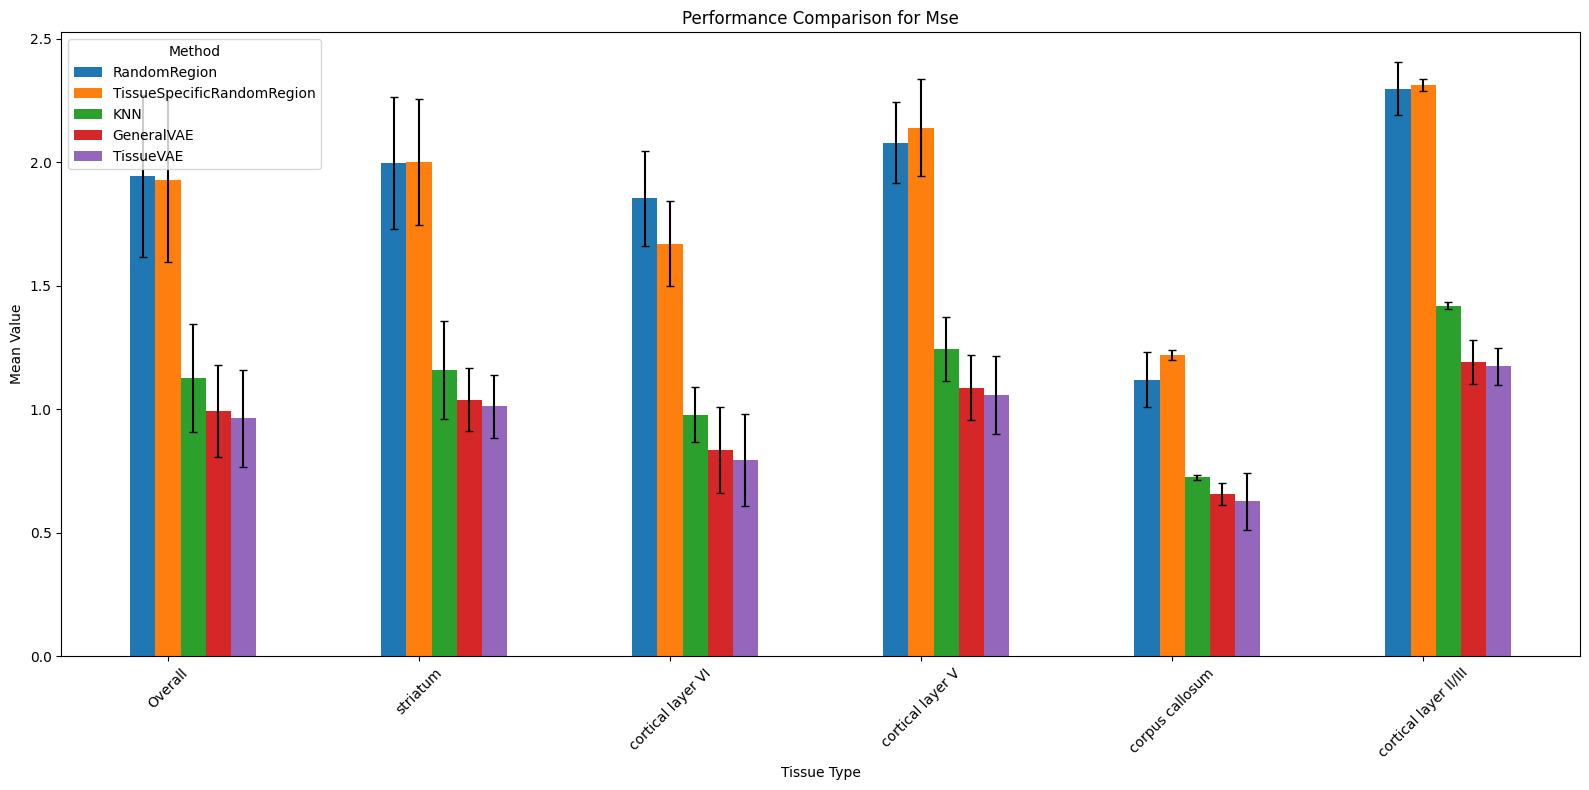

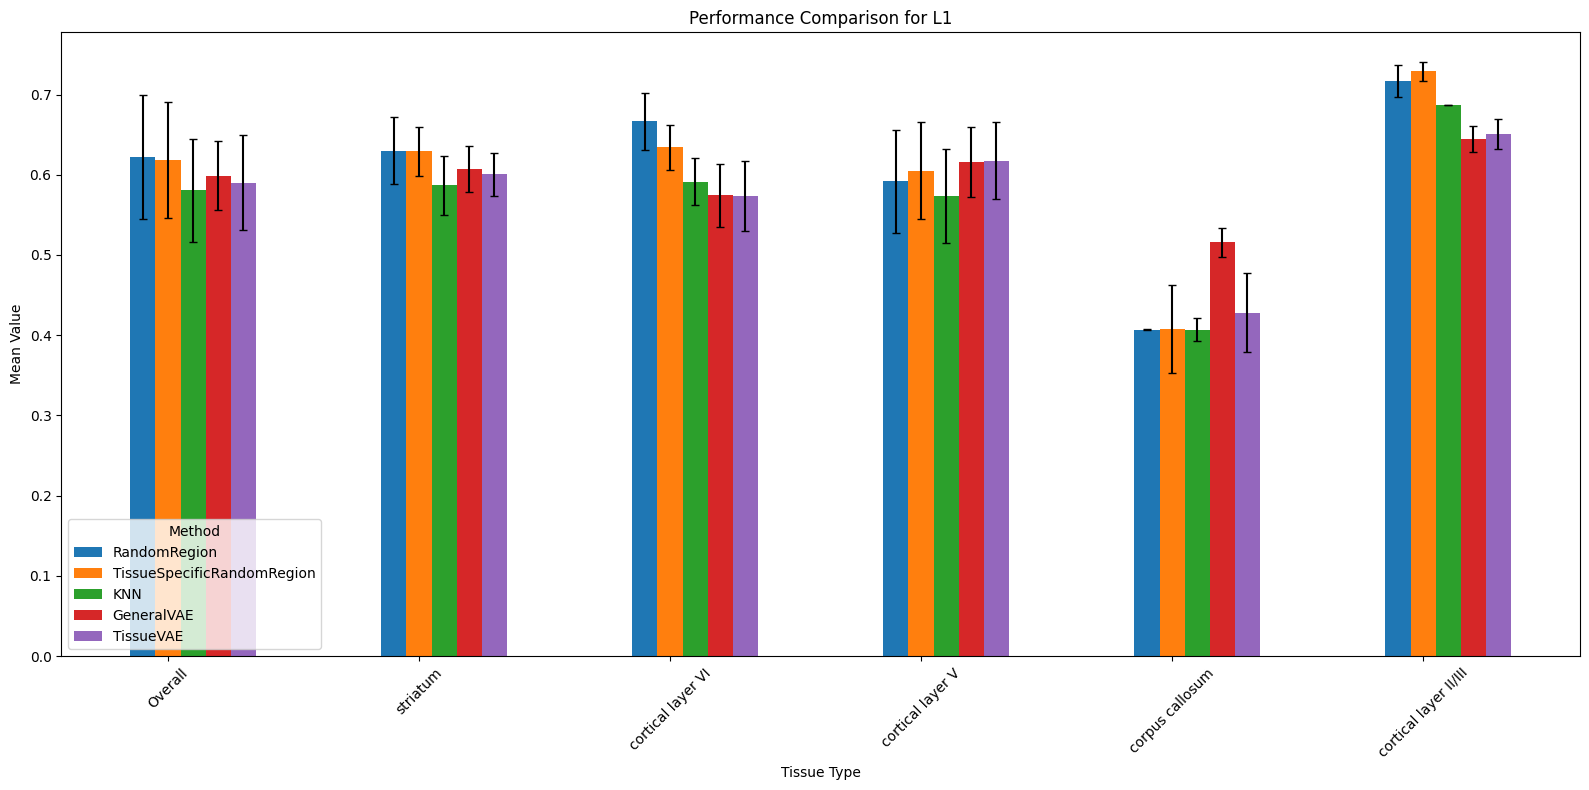

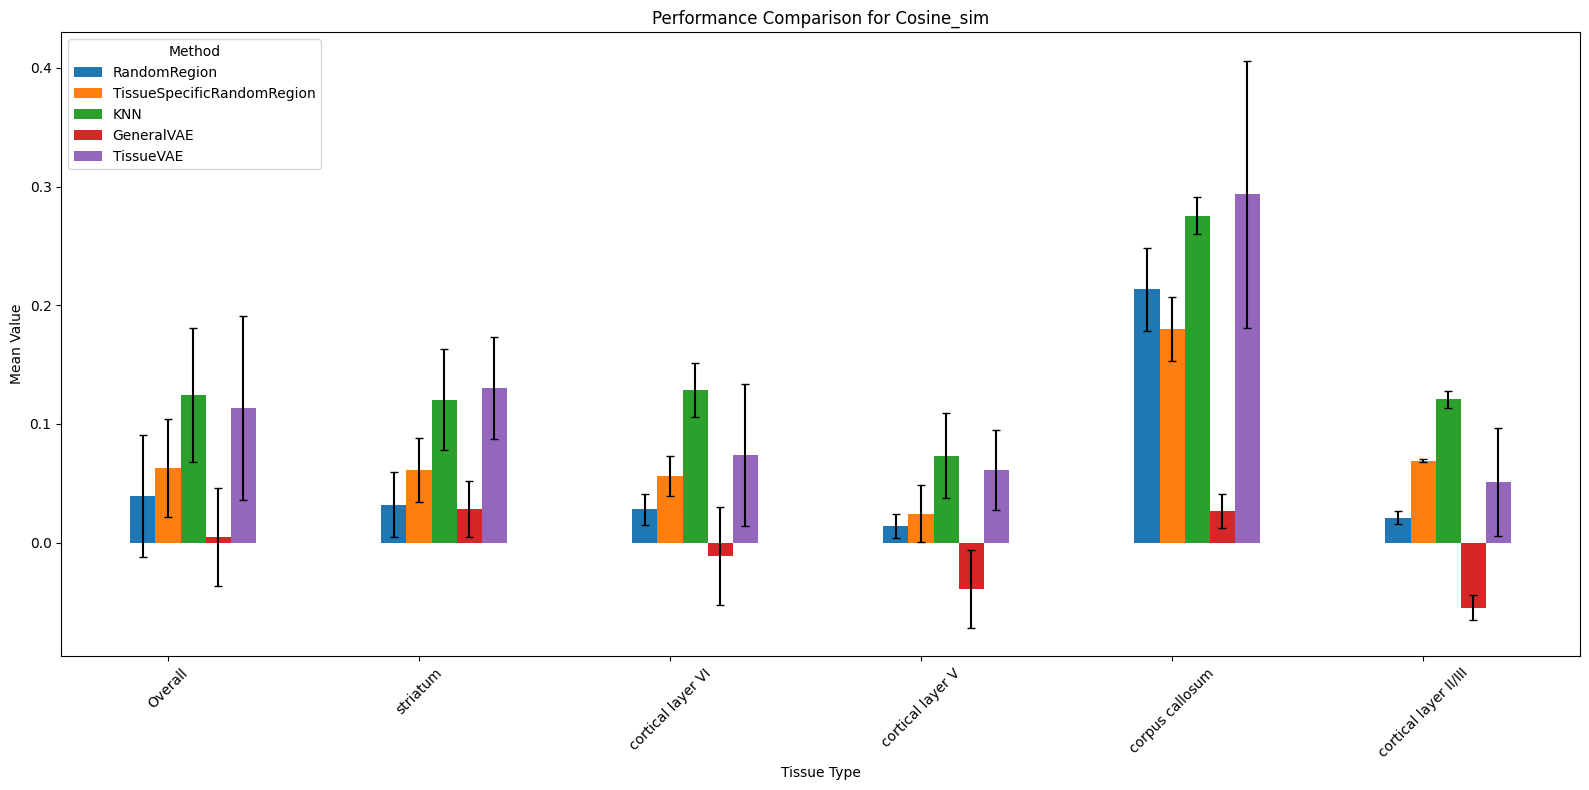

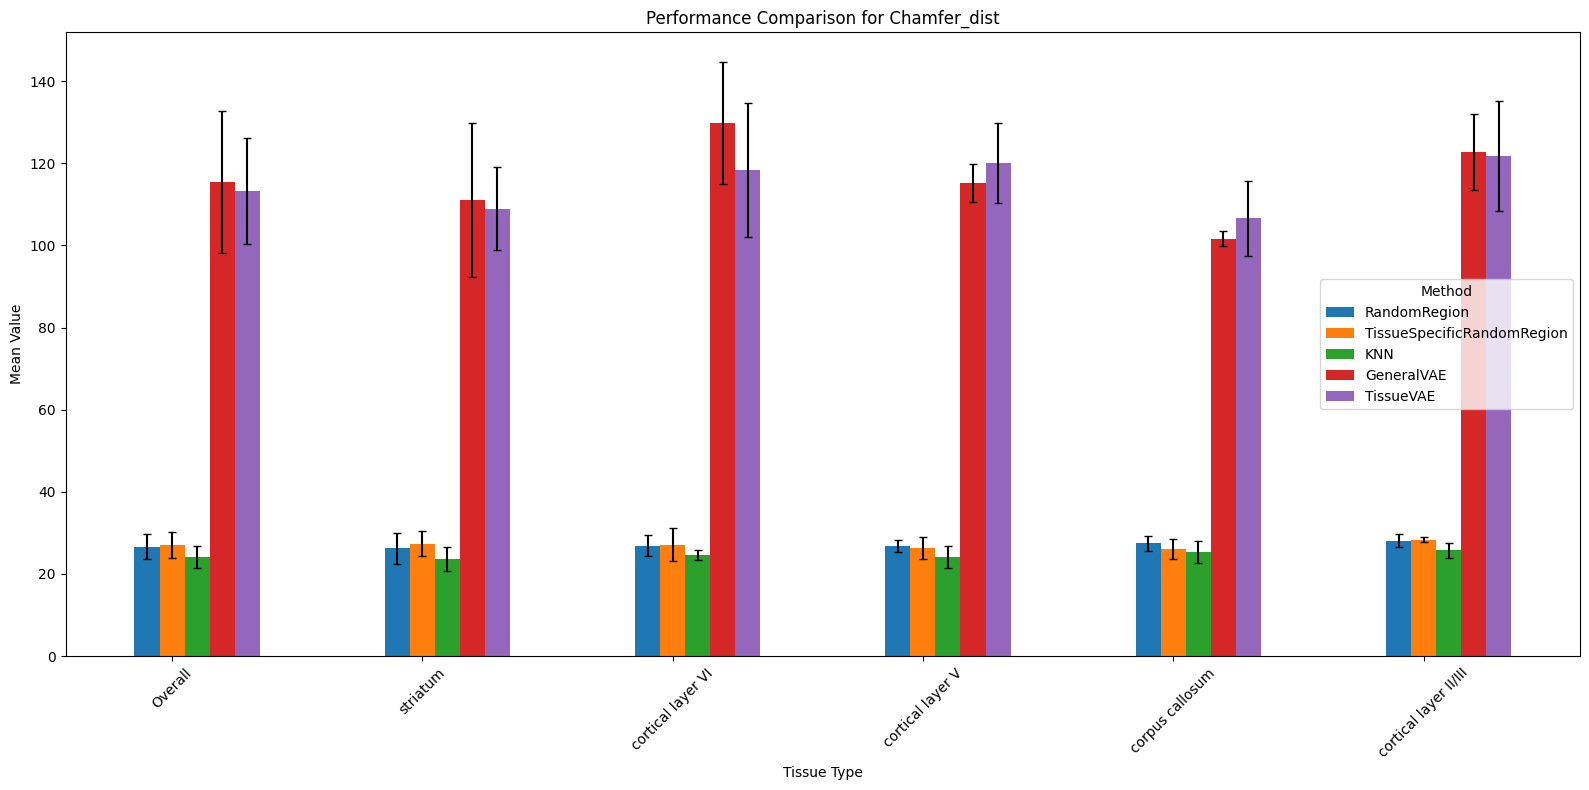

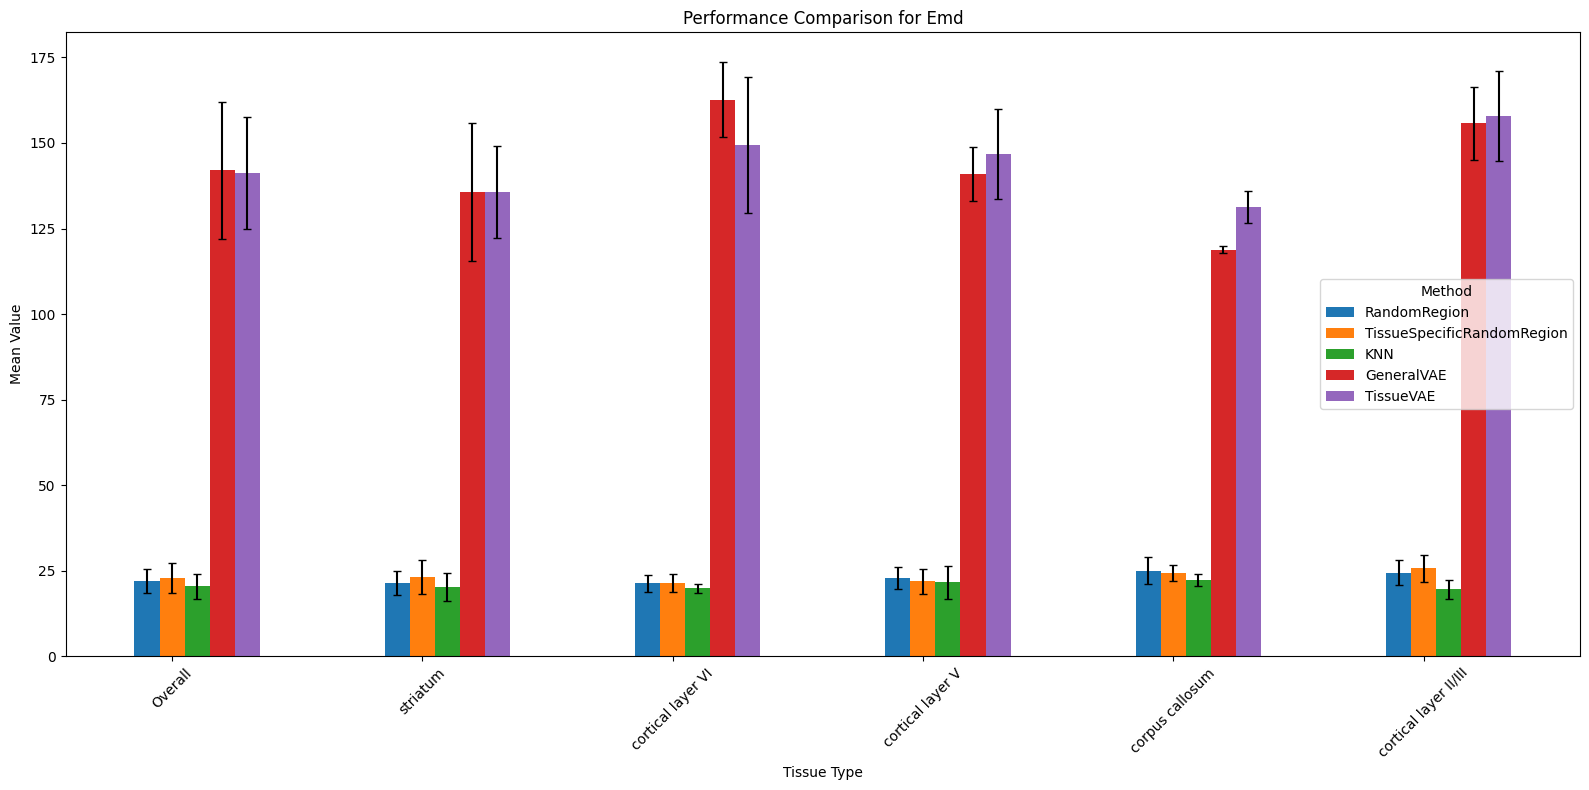

In [ ]:
overall_metrics = {
    method: {metric: [] for metric in ['mse', 'l1', 'cosine_sim', 'chamfer_dist', 'emd']}
    for method in ['RandomRegion', 'TissueSpecificRandomRegion', 'KNN', 
                   'GeneralVAE', 'TissueVAE',
                   'GeneralGAN', 'TissueGAN',
                   'GeneralLGAN', 'TissueLGAN']
}

for tissue in metrics:
    print(f"Results for {tissue}:")
    for method in metrics[tissue]:
        print(f"  {method}:")
        for metric in metrics[tissue][method]:
            values = metrics[tissue][method][metric]
            mean_value = np.mean(values)
            std_value = np.std(values)
            print(f"    {metric.capitalize()}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")
            
            overall_metrics[method][metric].extend(values)

for metric in ['mse', 'l1', 'cosine_sim', 'chamfer_dist', 'emd']:
    plt.figure(figsize=(16, 8))
    width = 0.1
    positions = np.arange(len(metrics) + 1)

    for i, method in enumerate(overall_metrics):
        overall_mean = np.mean(overall_metrics[method][metric])
        overall_std = np.std(overall_metrics[method][metric])

        method_means = [np.mean(metrics[tissue][method][metric]) for tissue in metrics]
        method_stds = [np.std(metrics[tissue][method][metric]) for tissue in metrics]

        means = [overall_mean] + method_means
        stds = [overall_std] + method_stds

        plt.bar(positions + i * width, means, yerr=stds, capsize=3, width=width, label=method)
        
    plt.xticks(positions + width, ['Overall'] + list(metrics.keys()), rotation=45)
    plt.title(f"Performance Comparison for {metric.capitalize()}")
    plt.ylabel("Mean Value")
    plt.xlabel("Tissue Type")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()